In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tensorflow as tf

2024-03-20 19:32:17.784396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 19:32:18.128474: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 19:32:19.655677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-03-20 19:32:19.655934: W tensorflow/compiler/xla/stre

In [5]:
import json
import sys

In [6]:
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
import matplotlib.pyplot as plt

In [8]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import (
    KoopmanBilinearDLSolver,
    KoopmanLinearDLSolver,
    KoopmanParametricDLSolver,
)
from koopmanlib.target import VanderPolMathieuTarget

In [9]:
config_file = "config_vdpm.json"

index = 0
with open(config_file, "r") as f:
    config = json.load(f)

data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]


n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]
mu = config["data_settings"]["mu"][index]

n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"][index]

In [10]:
dict_layer_size

[64, 64]

In [11]:
print("mu", mu)
print("K_layer_size", K_layer_size)

mu 0
K_layer_size [128]


In [12]:
target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

In [13]:
n_psi

13

In [14]:
# Set parameters in the vdpm equation.
k1, k2, k4, w0 = 2, 2, 1, 1

In [15]:
# Load data
dict_data = np.load(
    os.path.join(data_path, "vdpm_data_mu_" + str(mu) + ".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

In [16]:
vdp_mathieu = VanderPolMathieuTarget(
    mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
)

In [17]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

# Set Linear weights into PKNN
## Design the activation function


In [18]:

@tf.function
def hard_tanh(x):
    return tf.clip_by_value(x, clip_value_min=-1., clip_value_max=1.)

In [19]:
hard_tanh(data_u)

2024-03-20 19:32:28.089799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-20 19:32:28.089935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-03-20 19:32:28.089944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-03-20 19:32:28.090341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.239.6
2024-03-20 19:32:28.090398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.239.6
2024-03-20 19:32:28.090404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.239.6
2024-03-20 19:32:28.092019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

<tf.Tensor: shape=(50000, 1), dtype=float64, numpy=
array([[-0.16595599],
       [ 0.44064899],
       [-0.99977125],
       ...,
       [ 0.52979385],
       [-0.92560571],
       [ 0.7583709 ]])>

In [20]:
data_u

array([[-0.16595599],
       [ 0.44064899],
       [-0.99977125],
       ...,
       [ 0.52979385],
       [-0.92560571],
       [ 0.7583709 ]])

In [21]:
from koopmanlib.K_structure import Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation=hard_tanh)

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

In [22]:
zeros_data_y_train = tf.zeros_like(dic_pk(data_y))

model_pk.compile(optimizer=Adam(0.001), loss="mse")


lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=100,
    verbose=0,
    mode="auto",
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-10,
)

# Define the early stopping criteria
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-12, patience=50, verbose=1, mode="auto"
)

checkpoint_path = os.path.join(weights_path, "hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
)

from tqdm.keras import TqdmCallback
# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Add early_stopping to the list of callbacks
callbacks = [lr_callback, checkpoint_callback, tqdm_callback]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [23]:

# pknn_epochs = config["nn_settings"]["pknn_epochs"]

# history_pk = model_pk.fit(
# x=[data_x, data_y, data_u],
# y=zeros_data_y_train,
# validation_split=0.2,
# epochs=pknn_epochs,
# batch_size=200,
# callbacks=callbacks,
# verbose=0,
# )


In [24]:
model_pk.load_weights(os.path.join(weights_path, "hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5"))

# DMDc

In [25]:
# dic_dmdc = PsiNN(n_psi_train=0, add_constant=False)
# solver_dmdc = KoopmanLinearDLSolver(
#     dic=dic_dmdc, target_dim=target_dim, param_dim=param_dim, n_psi=target_dim
# )
# model_dmdc, model_K_u_pred_dmdc = solver_dmdc.build_model()
# dic_dmdc.generate_B(data_x)

# Linear Model: Dynamics is $Az +Bu$

In [26]:
dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [27]:
solver_linear = KoopmanLinearDLSolver(
    dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_linear, model_K_u_pred_linear = solver_linear.build_model()

In [28]:
model_linear.load_weights(os.path.join(weights_path, "model_linear_vdpm_mu_" + str(mu) + ".h5"))

## Try to set Linear weights

In [29]:
dic_pk_faker = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)
dic_pk_faker(data_x)

# Set weigths in dictionary the same as linear Koopman model
dic_pk_faker.set_weights(dic_linear.get_weights())

In [30]:
# Set updated dictionary into PKNN, then build model_pk_faker
model_K_u_faker = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation=hard_tanh)

solver_pk_faker = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk_faker, model_K_u=model_K_u_faker
)

model_pk_faker, model_K_u_pred_pk_faker = solver_pk_faker.generate_model()

In [31]:
# Extract weights from linear Koopman model
K_linear_weights = model_linear.get_layer('K_u_linear_pred').weights

In [32]:
len(model_pk_faker.get_layer('K_u_pred').weights)

4

In [33]:
# Consider the hidden layers in K(u)
# weights and bias, somehow set weights as identity mappings and bias are zeros
hidden_dense_kernel = model_pk_faker.get_layer('K_u_pred').weights[0]
model_pk_faker.get_layer('K_u_pred').weights[0].assign(
    tf.Variable(tf.constant([([1.0] * hidden_dense_kernel.shape[1] if i == 0 else [0.0] * hidden_dense_kernel.shape[1]) for i in range(hidden_dense_kernel.shape[0])], dtype='float64'))
    )
model_pk_faker.get_layer('K_u_pred').weights[1].assign(
    tf.zeros_like(model_pk_faker.get_layer('K_u_pred').weights[1])
    )

<tf.Variable 'UnreadVariable' shape=(128,) dtype=float64, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])>

In [34]:
# Consider the output layers in K(u)

# Delete the first column (1, 0, ...,0)^T,
# need to be careful with the transposed form of weights in formula and the codes
# B in linear Koopman can be considered as the weights of the output layer
# Set the first (n_psi - 1) diagonal elements are the components of B
trainable_B_from_linear = K_linear_weights[1][:,1:] 
zero_B_matrix = np.zeros(model_pk_faker.get_layer('K_u_pred').weights[2].shape, dtype='float64')
for i in range(trainable_B_from_linear.shape[-1]):
    zero_B_matrix[i,i] = trainable_B_from_linear[0,i]


# A in linear Koopman can be considered as the bias of the output layer
set_output_layer_w_weights = tf.Variable(zero_B_matrix)
set_output_layer_bias_weights = tf.reshape(K_linear_weights[0][:,1:], shape=model_pk_faker.get_layer('K_u_pred').weights[3].shape)

model_pk_faker.get_layer('K_u_pred').weights[2].assign(
    set_output_layer_w_weights
    )
model_pk_faker.get_layer('K_u_pred').weights[3].assign(
    set_output_layer_bias_weights
    )

<tf.Variable 'UnreadVariable' shape=(156,) dtype=float64, numpy=
array([ 3.94845674e-05,  8.83166490e-03,  5.47554181e-03, -7.59532262e-03,
        2.46115773e-03,  7.83433572e-03,  8.80262722e-03, -7.51704222e-03,
       -5.67505755e-03, -1.74687247e-03,  1.56132159e-02, -6.59015747e-03,
        1.00076182e+00,  1.64890787e-01, -1.70957936e-02,  9.95357065e-02,
        6.67900079e-02, -1.16890575e-02,  3.26710991e-03, -3.45848265e-02,
       -3.90870076e-02, -6.52488721e-03, -3.49217570e-02,  4.53576238e-02,
        1.70822454e-02,  2.58764381e+00,  2.94701781e-01,  3.86317977e-01,
        1.95449750e-01,  3.44148848e-02,  4.04374561e-01, -4.15705962e-01,
       -6.15446124e-02, -3.83932386e-01,  4.28636474e-01,  1.45889252e-01,
       -2.91381707e-03, -6.59368608e-01,  7.29042180e-01,  1.98208311e-01,
       -8.48748538e-02, -2.42476507e-01, -4.18119602e-01,  3.60526782e-01,
        1.62695891e-01,  1.62142466e-01, -6.66483237e-01,  1.29357348e-01,
       -3.13395831e-03, -7.02352240

## Add Perturbation


In [35]:
percentage = 0.0001  # 1%

for layer in model_pk_faker.layers:
    if layer.weights:
        for weight in layer.weights:
            current_weight_value = weight.numpy()
            perturbation = tf.random.normal(current_weight_value.shape, stddev=percentage, dtype=weight.dtype)
            print('perturb: ', perturbation)
            weight.assign_add(perturbation)

perturb:  tf.Tensor(
[[ 9.52569244e-05 -3.80691924e-05 -2.67068618e-05  2.27785787e-05
   9.68711774e-05 -9.71647408e-05 -7.40043701e-05 -5.95135382e-05
  -1.48326293e-04  1.66766539e-04  1.32076297e-04 -2.46919874e-05
  -1.26692378e-04 -1.46656558e-04  7.79056549e-05 -3.57424074e-05
  -2.29453912e-05  6.28142957e-05 -2.07049276e-04  5.19765537e-05
   1.19508694e-04  5.09065607e-05 -1.02489269e-04 -4.72067236e-05
   6.94663072e-05  3.80044435e-05 -2.11662365e-04  6.17804169e-05
   1.14887888e-04 -5.37667500e-05  1.53740060e-04 -2.63286951e-06
  -3.66140850e-05 -1.55305131e-04 -9.87301625e-06  1.27068696e-04
   2.01853639e-05  9.51643019e-05 -9.68386377e-05  7.17555506e-05
  -1.59286779e-05  7.55311953e-05  1.45785543e-04 -6.55320298e-05
   7.45674121e-05  4.02093575e-05 -8.44286444e-05 -3.31790687e-05
  -7.37323762e-05 -6.98013429e-05  1.87920636e-06 -1.72659282e-04
   2.26170226e-05  2.71485673e-05  9.16458863e-05 -1.07370025e-04
  -3.34449137e-05  1.05849134e-04  9.89228159e-05 -1.14

## Continue to train from linear weights


In [36]:
model_pk_faker.compile(optimizer=Adam(1e-4), loss="mse")
    
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=100,
    verbose=0,
    mode="auto",
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-10,
)

# Define the early stopping criteria
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-12, patience=50, verbose=1, mode="auto"
)

checkpoint_path = os.path.join(weights_path, "train_from_linear_hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
)

from tqdm.keras import TqdmCallback

# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Add early_stopping to the list of callbacks
callbacks = [lr_callback, checkpoint_callback, tqdm_callback]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [37]:
# history_pk_faker = model_pk_faker.fit(
# x=[data_x, data_y, data_u],
# y=zeros_data_y_train,
# validation_split=0.2,
# epochs=pknn_epochs,
# batch_size=200,
# callbacks=callbacks,
# verbose=0,
# )

In [38]:
model_pk_faker.load_weights(os.path.join(weights_path, "train_from_linear_hardtanh_model_pk_vdpm_mu_" + str(mu) + ".h5"))

# Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

In [39]:
dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [40]:
solver_bilinear = KoopmanBilinearDLSolver(
    dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()

In [41]:
model_bilinear.load_weights(
    os.path.join(weights_path, "model_bilinear_vdpm_mu_" + str(mu) + ".h5")
)

In [42]:
model_K_u_pred_bilinear.summary()

Model: "K_u_bilinear_pred"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_17 (InputLayer)          [(None, 13)]         0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 tf.einsum (TFOpLambda)         (1, None, 13)        0           ['input_17[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 13)          0           ['tf.einsum[0][0]']              
 ingOpLambda)                                                                                     
                                                                                                  
 tf.identi

In [43]:


# # Train K(u) to be (A+Bu)
# psi_x_data = dic_bilinear(data_x)
# target = model_K_u_pred_bilinear([data_u, psi_x_data])
# inputs_u = Input(shape=(param_dim,))
# inputs_psi_x = Input(shape=(n_psi,))

# fake_psi = model_K_u_pred_pk([inputs_u, inputs_psi_x])

# test_K_model = Model(inputs=[inputs_u, inputs_psi_x], outputs=fake_psi)

# test_K_model.compile(optimizer=Adam(0.000001), loss="mse")
# test_K_model.fit(x=[data_u, psi_x_data], y=target, epochs=500, batch_size=200, verbose=1)
# dic_pk.set_weights(dic_bilinear.get_weights())



## Prediction

In [44]:
from koopmanlib.functions import *

## Calculate average value

In [45]:
np.random.seed(625)
n_test = 20
seed_x_list = np.random.randint(1, 300, size=(n_test,))
seed_param_list = np.random.randint(1, 300, size=(n_test,))
n_traj_test = 1
traj_len_test = 50

In [46]:
ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []
# ratio_dmdc_list = []
ratio_pk_faker_list = []

In [47]:
data_pred_list_pk_group = []
data_pred_list_linear_group = []
data_pred_list_bilinear_group = []
data_true_group = []
# data_pred_list_dmdc_group = []
data_pred_list_pk_faker_group = []


In [48]:
for seed_x, seed_param in zip(seed_x_list, seed_param_list):
    vdp_mathieu_test = VanderPolMathieuTarget(
        mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
    )

    data_x_test, data_u_test = vdp_mathieu_test.generate_init_data(
        n_traj=n_traj_test, traj_len=traj_len_test, seed_x=seed_x, seed_param=seed_param
    )
    data_x_init = tf.reshape(data_x_test[0], shape=(1, -1))
    data_true = data_x_test

    data_pred_list_pk = solver_pk.compute_data_list(traj_len_test, data_x_init, data_u_test)
    data_pred_list_pk_faker = solver_pk_faker.compute_data_list(traj_len_test, data_x_init, data_u_test)
    data_pred_list_linear = solver_linear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )
    data_pred_list_bilinear = solver_bilinear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )

    # data_pred_list_dmdc = solver_dmdc.compute_data_list(
    #     traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    # )

    ratio_pk = compute_diff_ratio_one_traj(data_true, data_pred_list_pk)
    ratio_linear = compute_diff_ratio_one_traj(data_true, data_pred_list_linear)
    ratio_bilinear = compute_diff_ratio_one_traj(data_true, data_pred_list_bilinear)
    # ratio_dmdc = compute_diff_ratio_one_traj(data_true, data_pred_list_dmdc)
    ratio_pk_faker = compute_diff_ratio_one_traj(data_true, data_pred_list_pk_faker)

    ratio_pk_list.append(ratio_pk)
    ratio_linear_list.append(ratio_linear)
    ratio_bilinear_list.append(ratio_bilinear)
    # ratio_dmdc_list.append(ratio_dmdc)
    ratio_pk_faker_list.append(ratio_pk_faker)

    data_pred_list_pk_group.append(data_pred_list_pk)
    data_pred_list_linear_group.append(data_pred_list_linear)
    data_pred_list_bilinear_group.append(data_pred_list_bilinear)
    # data_pred_list_dmdc_group.append(data_pred_list_dmdc)
    data_pred_list_pk_faker_group.append(data_pred_list_pk_faker)

    data_true_group.append(data_true)

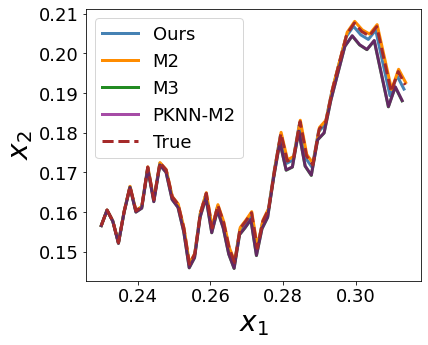

In [69]:
plt.figure(figsize=(6, 5))

plt.plot(
    data_pred_list_pk[:, 0], 
    data_pred_list_pk[:, 1], 
    label="Ours", 
    color="steelblue", 
    linewidth=3
)
    
plt.plot(
    data_pred_list_linear[:, 0],
    data_pred_list_linear[:, 1],
    label="M2",
    color="darkorange",
    linewidth=3,
)
plt.plot(
    data_pred_list_bilinear[:, 0],
    data_pred_list_bilinear[:, 1],
    label="M3",
    color="forestgreen",
    linewidth=3,
)

# plt.plot(
# data_pred_list_dmdc[:,0],
# data_pred_list_dmdc[:,1],
# label='DMDc',
# color='red',
# linewidth=3
# )

plt.plot(
    data_pred_list_pk_faker[:, 0], 
    data_pred_list_pk_faker[:, 1], 
    label="PKNN-M2", 
    color="purple", 
    linewidth=3,
    alpha=0.7
)


plt.plot(
    data_true[:, 0], data_true[:, 1], label="True", color="brown", linestyle="dashed", linewidth=3
)
plt.xlabel(r"$x_{1}$", fontsize=28)
plt.ylabel(r"$x_{2}$", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.savefig(os.path.join(figures_path, 'traj_linear_perturb_vdpm_'+str(mu)+'_.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'traj_linear_perturb_vdpm_'+str(mu)+'_.pdf'), dpi=200, bbox_inches='tight')


In [51]:
data_pred_list_pk_group = np.asarray(data_pred_list_pk_group)
data_pred_list_linear_group = np.asarray(data_pred_list_linear_group)
data_pred_list_bilinear_group = np.asarray(data_pred_list_bilinear_group)
# data_pred_list_dmdc_group = np.asarray(data_pred_list_dmdc_group)
data_pred_list_pk_faker_group = np.asarray(data_pred_list_pk_faker_group)
data_true_group = np.asarray(data_true_group)

In [52]:
# for i in range(data_pred_list_pk_group.shape[0]):
#     plt.figure(figsize=(6, 5))
#     plt.plot(
#         data_pred_list_pk_group[i, :, 0],
#         data_pred_list_pk_group[i, :, 1],
#         label="Ours",
#         color="steelblue",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_linear_group[i, :, 0],
#         data_pred_list_linear_group[i, :, 1],
#         label="M2",
#         color="darkorange",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_bilinear_group[i, :, 0],
#         data_pred_list_bilinear_group[i, :, 1],
#         label="M3",
#         color="forestgreen",
#         linewidth=3,
#     )
#     plt.plot(
#         data_true_group[i, :, 0],
#         data_true_group[i, :, 1],
#         label="True",
#         color="brown",
#         linestyle="dashed",
#         linewidth=3,
#     )
#     plt.xlabel(r"$x_{1}$", fontsize=28)
#     plt.ylabel(r"$x_{2}$", fontsize=28)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.legend(fontsize=18)

In [53]:
ratio_pk_list = np.asarray(ratio_pk_list)
ratio_linear_list = np.asarray(ratio_linear_list)
ratio_bilinear_list = np.asarray(ratio_bilinear_list)
# ratio_dmdc_list = np.asarray(ratio_dmdc_list)
ratio_pk_faker_list = np.asarray(ratio_pk_faker_list)

In [54]:
ratio_pk_list_mean = np.mean(ratio_pk_list, axis=0)
ratio_linear_list_mean = np.mean(ratio_linear_list, axis=0)
ratio_bilinear_list_mean = np.mean(ratio_bilinear_list, axis=0)
# ratio_dmdc_list_mean = np.mean(ratio_dmdc_list, axis=0)
ratio_pk_faker_list_mean = np.mean(ratio_pk_faker_list, axis=0)

In [55]:
ratio_pk_list_median = np.median(ratio_pk_list, axis=0)
ratio_linear_list_median = np.median(ratio_linear_list, axis=0)
ratio_bilinear_list_median = np.median(ratio_bilinear_list, axis=0)
# ratio_dmdc_list_median = np.median(ratio_dmdc_list, axis=0)
ratio_pk_faker_list_median = np.median(ratio_pk_faker_list, axis=0)

In [56]:
q_min = 0.35
q_max = 0.65

In [57]:
ratio_pk_list

array([[0.00000000e+00, 1.08002377e-04, 2.03615975e-04, 3.01131228e-04,
        4.00254354e-04, 4.99888098e-04, 5.99304956e-04, 6.98935822e-04,
        7.99435169e-04, 9.00911523e-04, 1.00299172e-03, 1.10484419e-03,
        1.20616149e-03, 1.30617470e-03, 1.40491244e-03, 1.50188627e-03,
        1.59667392e-03, 1.68908564e-03, 1.77910571e-03, 1.86665527e-03,
        1.95118170e-03, 2.03266036e-03, 2.11104409e-03, 2.18604299e-03,
        2.25746243e-03, 2.32521679e-03, 2.38890360e-03, 2.44831219e-03,
        2.50332792e-03, 2.55383758e-03, 2.59953883e-03, 2.63992909e-03,
        2.67458254e-03, 2.70314181e-03, 2.72566725e-03, 2.74217169e-03,
        2.75307803e-03, 2.75845489e-03, 2.75832480e-03, 2.75278734e-03,
        2.74249788e-03, 2.72798206e-03, 2.70951179e-03, 2.68795276e-03,
        2.66420214e-03, 2.63909116e-03, 2.61354313e-03, 2.58817267e-03,
        2.56403975e-03, 2.54278499e-03],
       [0.00000000e+00, 3.93370647e-05, 7.88818044e-05, 1.18151677e-04,
        1.60215690e-04,

In [58]:
ratio_pk_list_min = np.quantile(ratio_pk_list, q=q_min, axis=0)
ratio_linear_list_min = np.quantile(ratio_linear_list, q=q_min, axis=0)
ratio_bilinear_list_min = np.quantile(ratio_bilinear_list, q=q_min, axis=0)
# ratio_dmdc_list_min = np.quantile(ratio_dmdc_list, q=q_min, axis=0)
ratio_pk_faker_list_min = np.quantile(ratio_pk_faker_list, q=q_min, axis=0)

In [59]:
ratio_pk_list_max = np.quantile(ratio_pk_list, q=q_max, axis=0)
ratio_linear_list_max = np.quantile(ratio_linear_list, q=q_max, axis=0)
ratio_bilinear_list_max = np.quantile(ratio_bilinear_list, q=q_max, axis=0)
# ratio_dmdc_list_max = np.quantile(ratio_dmdc_list, q=q_max, axis=0)
ratio_pk_faker_list_max = np.quantile(ratio_pk_faker_list, q=q_max, axis=0)

In [60]:
x_axis = np.arange(0, traj_len_test, 1)

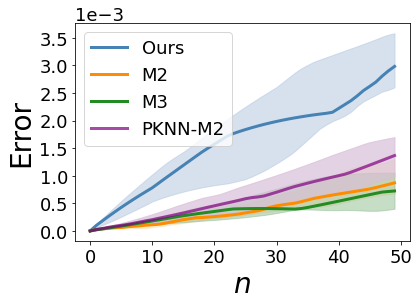

In [71]:
plt.figure(figsize=(6, 4))

plt.plot(ratio_pk_list_median, label="Ours", color="steelblue", linewidth=3)
plt.fill_between(x_axis, ratio_pk_list_min, ratio_pk_list_max, color="lightsteelblue", alpha=0.5)
plt.plot(ratio_linear_list_median, label="M2", color="darkorange", linewidth=3)
plt.fill_between(
    x_axis, ratio_linear_list_min, ratio_linear_list_max, color="navajowhite", alpha=0.5
)
plt.plot(ratio_bilinear_list_median, label="M3", color="forestgreen", linewidth=3)
plt.fill_between(
    x_axis, ratio_bilinear_list_min, ratio_bilinear_list_max, color="darkseagreen", alpha=0.5
)

plt.plot(ratio_pk_faker_list_median, label="PKNN-M2", color="purple", linewidth=3, alpha=0.7)
plt.fill_between(x_axis, ratio_pk_faker_list_min, ratio_pk_faker_list_max, color="thistle", alpha=0.7)


plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.savefig(os.path.join(figures_path, 'error_linear_perturb_vdpm_'+str(mu)+'_.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'error_linear_perturb_vdpm_'+str(mu)+'_.pdf'), dpi=200, bbox_inches='tight')
